In [720]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import re

In [570]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [571]:
train_df, test_df = None, None
ids = pd.DataFrame()

def load_data():
    global train_df, test_df

    train_df = pd.read_csv("data/train.csv")
    test_df = pd.read_csv("data/test.csv")
    
    ids["PassengerId"] = test_df["PassengerId"]

In [ ]:
load_data()

In [135]:
numerical_desc_train = train_df.describe()
categorical_desc_train = train_df.describe(include=["O"])

In [136]:
numerical_desc_train

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [137]:
categorical_desc_train

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Wilhelms, Mr. Charles",male,1601,B96 B98,S
freq,1,577,7,4,644


In [4]:
def survived_by(*args):
    cols = [arg for arg in args]
    return train_df[cols]. \
        groupby(cols[0], as_index=False).mean(). \
        sort_values(cols[len(cols)-1], ascending=False)

In [139]:
survived_by("Embarked", "Survived")

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [140]:
survived_by("Pclass", "Survived")

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [141]:
survived_by("Sex", "Survived")

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [142]:
survived_by("SibSp", "Survived")

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [80]:
survived_by("Parch", "Survived")

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


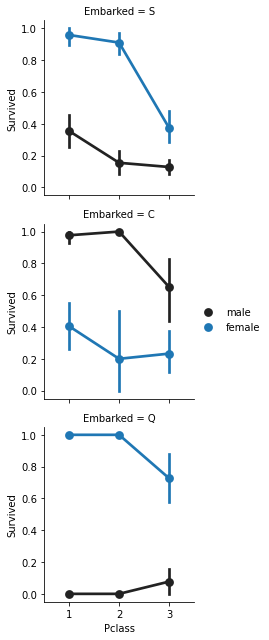

In [144]:
sg = sns.FacetGrid(train_df, row="Embarked")
sg.map(sns.pointplot, "Pclass", "Survived", "Sex")
sg.add_legend()

In [9]:
train_df.isna().sum().sort_values(ascending=False)

Age         177
Embarked      2
Title         0
Fare          0
Parch         0
SibSp         0
Sex           0
Pclass        0
Survived      0
dtype: int64

In [694]:
load_data()

In [695]:
# title feature

title_map = {
    "Miss": 1, "Mrs": 2, "Mr": 3, "Master": 4, "Boss": 5
}

sex_map = {
    "female": 1, "male": 0
}

boss_titles = [
    "Lady", "Countess", "Dona", 
    "Capt", "Col","Don", "Dr", 
    "Major", "Rev", "Sir", "Jonkheer"
]


def extract_title(df):
    df["Title"] = df.Name.str.extract("([A-Za-z]+)\.", expand=False)
    
    df["Title"] = df["Title"].replace(boss_titles, "Boss")
    df["Title"] = df["Title"].replace("Ms", "Miss")
    # replace french titles
    # mme = madame
    # mlle = mad...selle
    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")
    

def title_to_ord(df, cols, mappings):
    for i, col in enumerate(cols):
        df[col] = df[col].map(mappings[i])
    
    
extract_title(train_df)
extract_title(test_df)

title_to_ord(train_df, ["Title", "Sex"], [title_map, sex_map])
title_to_ord(test_df, ["Title", "Sex"], [title_map, sex_map])

In [696]:
def group_ages(df, num=6):
    age_df = df[["Survived"]]
    age_df["AgeGroup"] = pd.cut(df["Age"], num)
    
    return age_df[["AgeGroup", "Survived"]].\
                groupby(["AgeGroup"], as_index=False).mean().\
                sort_values(by="AgeGroup")

In [697]:
# age feature

age_groups = {
    5: {
        0: (-0.08, 16.0),
        1: (16.0, 32.0),
        2: (32.0, 48.0),
        3: (48.0, 64.0),
        4: (64.0, 80.0)
    },
    6: {
        0: (-0.08, 13.333),
        1: (13.333, 26.667),
        2: (26.667, 40.0),
        3: (40.0, 53.333),
        4: (53.333, 66.667),
        5: (66.667, 80.0)
    },
    7: {
        0: (0.34, 11.789),
        1: (11.789, 23.157),
        2: (23.157, 34.526),
        3: (34.526, 45.894),
        4: (45.894, 57.263),
        5: (57.263, 68.631),
        6: (68.631, 80.0)
    }
}

def fill_na_age(df):
    sex = [0, 1]
    pclass = [1, 2, 3]
    ages = np.zeros(shape=(2, 3))
    for i in sex:
        for j in pclass:
            med = df[(df["Sex"] == i) & \
                     (df["Pclass"] == j)]["Age"].dropna()
            
            ages[i, j-1] = int(med.median())
            
    for i in sex:
        for j in pclass:
            df.loc[(df.Age.isna()) & \
                   (df.Sex == i) & \
                   (df.Pclass == j), "Age"] = int(ages[i, j-1])
    
    df["Age"] = df["Age"].astype(int)
    
    
def age_to_ord(df, group=6):
    for k, v in age_groups[group].items():
        if k == 0:
            df.loc[df["Age"] <= v[1], "Age"] = k
        elif k == (group - 1):
            df.loc[df["Age"] > v[0], "Age"] = k
        else:
            df.loc[(df["Age"] > v[0]) & (df["Age"] <= v[1]), "Age"] = k
            
        df["Age"] = df["Age"].astype(int)
        
        
fill_na_age(train_df)
fill_na_age(test_df)

age_to_ord(train_df, group=6)
age_to_ord(test_df, group=6)

In [698]:
# embarked feature

port_map = {"S": 0, "C": 1, "Q": 2}

def fill_na_embarked(df):
    df["Embarked"] = df["Embarked"].fillna("S")
    
    
def embarked_to_ord(df):
    df["Embarked"] = df["Embarked"].map(port_map).astype(int)
        
        
fill_na_embarked(train_df)
fill_na_embarked(test_df)

embarked_to_ord(train_df)
embarked_to_ord(test_df)

In [699]:
def group_fares(df, num=5):
    fare_df = df[["Survived"]]
    fare_df["FareGroup"] = pd.qcut(df["Fare"], num)
    
    return fare_df[["FareGroup", "Survived"]].\
                groupby(["FareGroup"], as_index=False).mean().\
                sort_values(by="FareGroup")

In [700]:
# fare feature

fare_groups = {
    4: {
        0: (-0.001, 7.91),
        1: (7.91, 14.454),
        2: (14.454, 31.0),
        3: (31.0, 512.329)
    },
    5: {
        0: (-0.001, 7.854),
        1: (7.854, 10.5),
        2: (10.5, 21.679),
        3: (21.679, 39.688),
        4: (39.688, 512.329)
    }
}

def fill_na_fare(df):
    df["Fare"].fillna(df["Fare"].dropna().median(), inplace=True)
    

def fare_to_ord(df, group=5):
    for k, v in fare_groups[group].items():
        if k == 0:
            df.loc[df["Fare"] <= v[1], "Fare"] = k
        elif k == (group - 1):
            df.loc[df["Fare"] > v[0], "Fare"] = k
        else:
            df.loc[(df["Fare"] > v[0]) & (df["Fare"] <= v[1]), "Fare"] = k
    
        df["Fare"] = df["Fare"].astype(int)

        
fill_na_fare(train_df)
fill_na_fare(test_df)

fare_to_ord(train_df, group=5)
fare_to_ord(test_df, group=5)

In [701]:
# deck feature

deck_map = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8, "T": 9}

def create_deck(df):
    df["Cabin"] = df["Cabin"].fillna("U")
    df["Deck"] = df["Cabin"].map(lambda x: x[0])
    df["Deck"] = df["Deck"].map(deck_map).astype(int)
    

create_deck(train_df)
create_deck(test_df)

In [702]:
# family feature

def create_family(df):
    df["Members"] = df["Parch"] + df["SibSp"] + 1
    
create_family(train_df)
create_family(test_df)

In [703]:
train_df.drop(columns=["PassengerId", "Name", "Cabin", "Ticket", "Parch", "SibSp"], inplace=True)
test_df.drop(columns=["PassengerId", "Name", "Cabin", "Ticket", "Parch", "SibSp"], inplace=True)

In [704]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df

In [705]:
rf_params = {
    "max_depth": [4, 6, 8],
    "n_estimators": [120, 80, 50, 20],
    "max_features": ["sqrt", "auto", "log2"],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "bootstrap": [True, False]
}

rf = RandomForestClassifier()
crv = StratifiedKFold(n_splits=5)

rf_grid = GridSearchCV(
    rf,
    scoring="accuracy",
    param_grid=rf_params,
    cv=crv
)

rf_grid.fit(X_train, Y_train)

score = rf_grid.best_score_
rf_best = rf_grid.best_params_

print("Best score {}".format(score))
print("Best params {}".format(rf_best))

Best score 0.8361559224154165
Best params {'bootstrap': True, 'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 50}


In [678]:
lr_params = {"C":  [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr = LogisticRegression()

lr_grid = GridSearchCV(
    lr,
    param_grid=lr_params
)

lr_grid.fit(X_train, Y_train)

score = lr_grid.best_score_
lr_best = lr_grid.best_params_

print("Best score {}".format(score))
print("Best params {}".format(lr_best))

Best score 0.812560416797439
Best params {'C': 100}


In [692]:
knn_params = {
    "n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                    16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
}

knn = KNeighborsClassifier()

knn_grid = GridSearchCV(
    knn,
    param_grid=knn_params, 
    cv=10, 
    scoring='accuracy'
)

knn_grid.fit(X_train, Y_train)

score = knn_grid.best_score_
knn_best = knn_grid.best_params_

print("Best score {}".format(score))
print("Best params {}".format(knn_best))

Best score 0.8249687890137327
Best params {'n_neighbors': 9}


In [717]:
def score(model, X, y):
    return np.mean(cross_val_score(model, X, y, cv=5, scoring="accuracy"))

In [718]:
print("RForest score: {}".format(score(RandomForestClassifier(**rf_best), X_train, Y_train)))

RForest score: 0.8215366267026554


In [681]:
print("LogReg score: {}".format(score(LogisticRegression(**lr_best), X_train, Y_train)))

LogReg score: 0.812560416797439


In [677]:
print("Knn score: {}".format(score(KNeighborsClassifier(**knn_best), X_train, Y_train)))

Knn score: 0.8148138848785387


In [690]:
model = RandomForestClassifier(**rf_best)
# model = LogisticRegression(**lr_best)
# model = KNeighborsClassifier(**knn_best)

model.fit(X_train, Y_train)

y_out = model.predict(X_test).astype(int)

out = pd.DataFrame({
    "PassengerId": ids["PassengerId"],
    "Survived": y_out
})
out.to_csv("data/submission.csv", index=False)